In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.autograd
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import gym
from collections import deque
import random
import sys
import pandas as pd
import matplotlib.pyplot as plt
from numpy import cos, sin
from gym import spaces
from gym.error import DependencyNotInstalled
from typing import Optional
from control.matlab import ss, lsim, linspace, c2d
from functools import partial
from state_estimation import Estimator
import math
import gym
from stable_baselines3 import PPO, SAC, TD3, DDPG, DQN, A2C
from stable_baselines3.common.env_checker import check_env

In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [132]:
class DCEnv(gym.Env):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }

    def __init__(self, render_mode: Optional[str] = None, g=10.0):
        super(DCEnv, self).__init__()
        self.max_speed = -10
        self.max_torque = 10
        self.dt = 0.05

        self.render_mode = render_mode

        self.screen_dim = 500
        self.screen = None
        self.clock = None
        self.isopen = True
        self.center = np.array([math.pi / 2.0, 0, 0])
        self.obstacle = np.array([math.pi / 4.0, 0, 0])
        count = 0
        J = 0.01
        b = 0.1
        K = 0.01
        R = 1
        L = 0.5
        self.A = np.array([[0, 1, 0],
         [0, -b / J, K / J],
         [0, -K / L, -R / L]])
        self.A_dim = len(self.A)
        self.B = np.array([[0], [0], [1 / L]])
        self.xmeasure = 0
        self.attacked_element_idx = 0
        self.C = np.array([[1, 0, 0]])
        self.D = np.array([[0]])
        self.Q = np.eye(self.A_dim)
        self.R = np.array([[1]])
        self.dt = 0.2
        self.x_ref = np.array([[0], [0], [0]]) # 4th dim is remaining steps
        # store current trace
        self.cache1 = []
        self.cache2 = []
        self.cache3 = []
        self.x0 = np.copy(self.x_ref)
        self.u_upbound_tuned = np.array([[10]])
        # ball radius
        self.target_norm_radius = 0.5 # norm ball radius of target, tune this
        self.safe_norm_radius = 0.3 # norm ball radius of safe, tune this
        self.total_time = 120
        # step number
        self.steps = 0
        self.u_lowbound = None
        # store training traces
        self.state_array_1 = []
        self.state_array_2 = []
        self.state_array_3 = []
        self.caches = []
        self.reward_cache = [] # cache distances to target norm ball center
        self.avoid_reward_cache = [] # cache distances to obstacles norm ball center
        self.final_reward_cache = [] # cache final reward
        # How long should this trace be, i.e. deadline
        self.step_const = random.randint(10, 50)
        # Maximum reward from each trace
        self.max_reward_list = []
        self.quality_list = []
        self.total_steps = 0
        self.step_history = []
        self.sysc = ss(self.A, self.B, self.C, self.D)
        self.sysd = c2d(self.sysc, self.dt)
        
        high = np.array(self.x_ref.flatten(), dtype=np.float32)
        self.action_space = spaces.Box(
            low=-self.max_torque, high=self.max_torque, shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)
        self.reached = False
        self.k = 20
    def step(self, u):
        
        # simulate next step and get measurement
        self.steps += 1
        self.total_steps += 1
        terminated = False
        dt = self.dt
        u = np.clip(u, -self.max_torque, self.max_torque)[0]
        self.last_u = u 
        costs = 1
        yout, T, xout = lsim(self.sysc, self.last_u, [0, self.dt], self.xmeasure)
        self.xmeasure = xout[-1]
        
        # calculate euclidean distance and update reward cache
        dist = np.linalg.norm(self.xmeasure - self.center)
        obs_dist = np.linalg.norm(self.xmeasure - self.obstacle)
        reward = self.target_norm_radius - dist
        obs_reward = obs_dist-self.safe_norm_radius
        
        self.reward_cache.append(reward)
        self.avoid_reward_cache.append(obs_reward)
        # quantitative semantics
        # reach reward, encourage reaching target
        if self.steps < 10:
            reach_reward = max(self.reward_cache)
        else:
            reach_reward = max(self.reward_cache[-10:])
        if self.steps < 10:
            avoid_reward = min(self.avoid_reward_cache)
        else:
            avoid_reward = min(self.avoid_reward_cache[-10:])          
                    
#         # very strict reward, always within target
#         strict_avoid_reward = avoid_reward - 0.5 * self.safe_norm_radius # half safe norm radius
#         strict_reach_reward = reach_reward - 0.5 * self.target_norm_radius # half target norm radius
        
        # overall reward, pick one of the final_reward
#         final_reward = reach_reward
#         final_reward = approach_reward
        final_reward = min(reach_reward, avoid_reward) # reach and avoid
#         final_reward = min(approach_reward, avoid_reward) # approach and avoid
#         final_reward = min(reach_reward, approach_reward) # reach and approach
#         deadline_reward = (self.last_dist-dist)/(self.step_const - self.steps+1) 
#         final_reward = reach_reward
        # split cases: if already inside target, give very large constant reward for maintaining
        if dist <= self.target_norm_radius:
            final_reward = 10 # this gives 39/50 sucess with reach+approach+avoid
        
        self.final_reward_cache.append(final_reward)
        
        # update cached memory
        self.state = self.xmeasure
        self.state_array_1.append(self.state[0])
        self.state_array_2.append(self.state[1])
        self.state_array_3.append(self.state[2])
        self.cache1.append(self.state[0])
        self.cache2.append(self.state[1])
        self.cache3.append(self.state[2])
        self.last_dist = dist
        # If this is the last step, reset the state
        if self.steps == self.step_const or obs_dist<=self.safe_norm_radius:
            self.max_reward_list.append(max(self.final_reward_cache)) # use max final reward to measure episodes
            self.step_history.append(self.total_steps)
            self.quality_list.append(sum(self.final_reward_cache))
            terminated = True
            self.reset()
            
#         # If within target norm ball, early terminate
#         if dist <= self.target_norm_radius:
#             terminated = True
#             self.reset()
        
        # Return next state, reward, done, info
        return self._get_obs(), final_reward, terminated, {}
        
    def reset(self):
        self.state = np.array([random.random()*math.pi - 1, random.random()*2-1, random.random()*20-10])
        self.reward_cache = []
        self.final_reward_cache = []
        self.steps=0
        self.caches.append(self.cache1)
        self.caches.append(self.cache2)
        self.caches.append(self.cache3)
        self.cache1 = []
        self.cache2 = []
        self.cache3 = []
        self.xmeasure = self.state
        # random # of steps for this trace
        self.step_const = self.k # deadline range
        self.reached = False
        return np.array(self.state) # return something matching shape
    
    def _get_obs(self):
        current_state = list(self.state)
        return np.array(current_state)
    
    def render(self):
        return
    
    def close(self):
        if self.screen is not None:
            import pygame
            pygame.display.quit()
            pygame.quit()
            self.isopen = False

In [10]:
reached = []
for k in [10]:
    env = DCEnv()
    env.k = k
    print('Start training with PPO ...')
    # learning_rate = 1e-3, n_steps = 1024, tune these
    model = SAC("MlpPolicy", env, verbose=0)
    model.learn(total_timesteps=300000, progress_bar=False)
    vec_env = model.get_env()
    obs = vec_env.reset()
    env = DCEnv()
    env.k = 160
    state = env.reset()
    dims0 = []
    dims1 = []
    dims2 = []
    euclids = []
    center = np.array([math.pi / 2.0, 0, 0])
    obstacle = np.array([math.pi / 4.0, 0, 0])
    num_reached = 0
    for j in range(1000):
        dim0 = []
        dim1 = []
        dim2 = []
        euclid = []
        state = env.reset()
        # Print initial state
        for i in range(30):
            action, _states = model.predict(state, deterministic=True)
            new_state, reward, done, _ = env.step(action)
            dim0.append(state[0])
            dim1.append(state[1])
            dim2.append(state[2])
            dist = np.linalg.norm(state[:3]-center)
            obs_dist = np.linalg.norm(state[:3]-obstacle)
            euclid.append(dist)
            state = new_state
            if obs_dist <= 0.2:
                break
            if dist <= 0.5: # stop
                num_reached += 1
                break
        dims0.append(dim0)
        dims1.append(dim1)
        dims2.append(dim2)
        euclids.append(euclid)
    reached.append(num_reached)
#     print("Total number reached = " + str(num_reached))
print(reached)

Start training with PPO ...
[1000]


In [12]:
# model.save('SAC_motor.zip')


In [20]:
# Test 50 traces

env = DCEnv()
model = SAC.load("SAC_motor.zip", env=env)
state = env.reset()
dims0 = []
dims1 = []
dims2 = []
euclids = []
center = np.array([math.pi / 2.0, 0, 0])
obstacle = np.array([math.pi / 4.0, 0, 0])
num_reached = 0
for j in range(1000):
    dim0 = []
    dim1 = []
    dim2 = []
    euclid = []
    state = env.reset()
    # Print initial state
    for i in range(env.step_const):
        action, _states = model.predict(state, deterministic=True)
        new_state, reward, done, _ = env.step(action)
        dim0.append(state[0])
        dim1.append(state[1])
        dim2.append(state[2])
        dist = np.linalg.norm(state[:3]-center)
        obs_dist = np.linalg.norm(state[:3]-obstacle)
        euclid.append(dist)
        state = new_state
        if obs_dist <= 0.2:
            break
        if dist <= 0.5: # stop
            num_reached += 1
            break
    dims0.append(dim0)
    dims1.append(dim1)
    dims2.append(dim2)
    euclids.append(euclid)
ref= [math.pi/2]*30
print("Total number reached = " + str(num_reached))

Total number reached = 1000


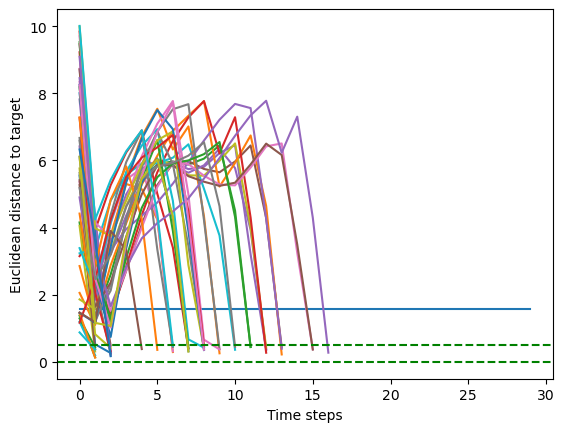

In [14]:
plt.plot(ref)
for i in range(50):
    plt.plot(euclids[i])
plt.axhline(y=0.5, color='g', linestyle='--')
plt.axhline(y=0, color='g', linestyle='--')
plt.plot()
plt.xlabel('Time steps')
plt.ylabel('Euclidean distance to target')
plt.show()

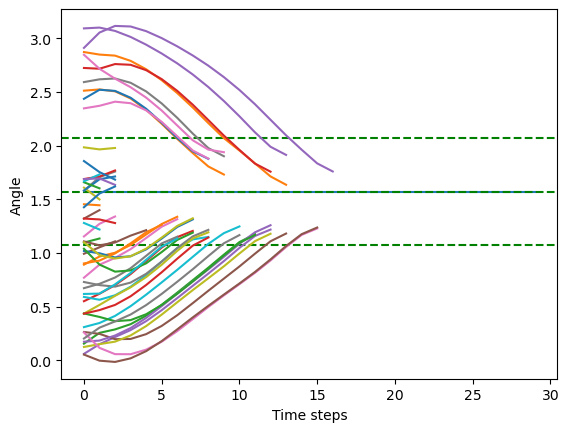

In [15]:
plt.plot(ref)
plt.axhline(y=1.07, color='g', linestyle='--')
plt.axhline(y=1.57, color='g', linestyle='--')
plt.axhline(y=2.07, color='g', linestyle='--')
for i in range(50):
    plt.plot(dims0[i])
plt.plot()
plt.xlabel('Time steps')
plt.ylabel('Angle')
plt.show()

In [16]:
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Max Overall Reward')
plt.show()

NameError: name 'reward_history' is not defined

In [174]:
# import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds, LinearConstraint, NonlinearConstraint, root
def fgsm_attack(state, model, epsilon, policy, norm, args):
    state = torch.from_numpy(state)
    state = state.detach().unsqueeze(0).requires_grad_(True)
    action = model.actor(state)
    # target = torch.argmax(q_vals).unsqueeze(0)
    # preds = torch.softmax(q_vals, 1)
    # The loss is calcualted with cross entropy
    # current_q = self.critic(state, action)
    # cri = model.critic(state)
    q_vals = (model.critic(state, action))
    loss = (q_vals[0] + q_vals[1]) / 2 * (-1)
    # print(target)
    # loss_func = torch.nn.CrossEntropyLoss()
    # loss = loss_func(preds, target)
    model.actor.zero_grad()
    
    loss.backward()
   
    state_grad = state.grad.detach().squeeze()
    
    state = state.squeeze()
    # Perturb only agent position and ball position
    if norm == float('inf'):
        perturbed_state = state + epsilon * state_grad.sign()
    elif norm == 2:
        perturbed_state = state + epsilon * state_grad / torch.norm(state_grad, norm)
    elif norm == 1:
        index = torch.argmax(state_grad)
        per = torch.zeros_like(state_grad)
        per[index] = 1
        perturbed_state = state + epsilon * per
    return perturbed_state.detach().cpu().numpy()

def safe_attack(env, state, model, epsilon, policy, norm, args):
    action = model.predict(state, deterministic=True)[0]
    # print(action)
    effect = None
    attack = None
    _action = action
    _state = state
    

    def fun(x):
        return np.linalg.norm( env.sysd.A @ _state + env.sysd.B @ x - env.obstacle) 
    
    x_start = np.array(action)
    lim = [-10, 10]

    bounds = Bounds(lim[0], lim[1])  

#     x_state = odeint(bicycle, state, ts, args=(action,))[-1]
#     non_linear_eq= lambda x: np.linalg.norm(odeint(bicycle, state, ts, args=(x,))[-1] - env.obstacle) -\
#                             np.linalg.norm(odeint(bicycle, state, ts, args=(action,))[-1] - env.obstacle)
#     non_linear_constr = NonlinearConstraint(non_linear_eq, 0.0, np.inf)
#     result = minimize(fun, x_start, method='trust-constr', bounds=bounds, constraints=non_linear_constr)
    result = minimize(fun, x_start, method='trust-constr', bounds=bounds)
    # print(result.x)
    op_action = (result.x)
    state = torch.from_numpy(state)
    
    state = state.detach().unsqueeze(0).requires_grad_(True)
    # print(model.predict(state, deterministic=True)[0])
    next_origin_obs_dist = np.linalg.norm( env.sysd.A @ _state + env.sysd.B @ _action - env.obstacle) 
    effect = next_origin_obs_dist
    for i in range(100):
     
        action = model.actor(state, deterministic=True)[0].requires_grad_(True)
        action = action * 10
        action = action.double()
        mse = nn.MSELoss()
        
        # compute the distance
        pdist = torch.nn.PairwiseDistance(p=2)
        loss = pdist(torch.tensor([op_action]), action)
        
        # loss = mse(torch.tensor([op_action]).requires_grad_(True), action)
        model.actor.zero_grad()
        loss = loss.double()
        # print(action.dtype)
        loss.backward()
       
        state_grad = state.grad.detach().squeeze()
        perturbed_state = state - epsilon / 10 * state_grad.sign()
        # print(state_grad)
        # project!
        # print(perturbed_state[0])
        # torch.clamp(perturbed_state, min=(state - epsilon), max=(state + epsilon))
        # print(perturbed_state[0])
        
        scaled_action = model.actor(perturbed_state, deterministic=True)[0]
        low, high = -10, 10
        action_next = (low + (0.5 * (scaled_action + 1.0) * (high - low)))
        # print(action_next.detach().numpy()
        state = perturbed_state.detach().requires_grad_(True)
        # print(f'state:{perturbed_state}')
    # print(f'action:{_action}, action_pertubed:{action_next}, op_action:{op_action}')
        dist = np.linalg.norm(_state - env.center)
        obs_dist = np.linalg.norm(_state - env.obstacle)
        pertub_dist = np.linalg.norm(state.detach().numpy() - env.center)
        pertub_obs_dist = np.linalg.norm(state.detach().numpy() - env.obstacle)
        next_obs_dist =  np.linalg.norm( env.sysd.A @ _state + env.sysd.B @ action_next.detach().numpy()- env.obstacle)
        if pertub_obs_dist - env.safe_norm_radius > 0:
            
            if next_obs_dist < effect:
                effect = next_obs_dist
                # print(effect)
                attack = (state.detach().numpy() - _state)[0]
    if attack is None:
        return np.zeros_like(_state)
    else:
        # print('find solution')
        return attack
        
    #     if np.minimum(env.target_norm_radius - pertub_dist, pertub_obs_dist - env.safe_norm_radius) >= \
    #         np.minimum(env.target_norm_radius - dist, obs_dist - env.safe_norm_radius):
            
    #         # print(_action)
    #         # print(action.detach())
    #         if next_obs_dist < next_origin_obs_dist:
    #             # print('find solution')
    #             if next_obs_dist < effect:
    #                 effect = next_obs_dist
    #                 # print(effect)
    #                 attack = (state.detach().numpy() - _state)[0]
                  
    # # print('not find solution')
    # if attack is None:
    #     return np.zeros_like(_state)
    # else:
    #     # print('find solution')
    #     return attack

    
# def safe_attack(env, state, model, epsilon, policy, norm, args):
    
#     action = model.predict(state, deterministic=True)[0]
#     _action = action
#     _state = state
#     # state = np.reshape(state, (3,1))
#     def f(x):
#     # Objective function
#         ts = [env.horizon[env.steps], env.horizon[env.steps+1] ]
        
#         return np.linalg.norm(odeint(bicycle, env.state, ts, args=(x,))[-1] - env.obstacle )
#     x_start = np.array(action)
#     lim = [-7, 7]

#     bounds = Bounds([lim[0], lim[0]], [lim[1], lim[1]])  

#     ts = [env.horizon[env.steps], env.horizon[env.steps+1] ]
#     x_state = odeint(bicycle, state, ts, args=(action,))[-1]
#     non_linear_eq= lambda x: env.target_norm_radius - np.linalg.norm(odeint(bicycle, state, ts, args=(x,))[-1] - env.center) +\
#     np.linalg.norm(odeint(bicycle, state, ts, args=(x,))[-1] - env.obstacle) - 0.3-\
#      (env.target_norm_radius - np.linalg.norm(odeint(bicycle, state, ts, args=(action,))[-1] - env.center) +\
#     np.linalg.norm(odeint(bicycle, state, ts, args=(action,))[-1] - env.obstacle) - 0.3)
    
#     dist = np.linalg.norm(x_state - env.center)
#     obs_dist = np.linalg.norm(x_state - env.obstacle)
#     reward = env.target_norm_radius - dist + obs_dist - 0.3
#     non_linear_constr = NonlinearConstraint(non_linear_eq, 0.0, np.inf)
#     # result = minimize(f, x_start, method='trust-constr', bounds=bounds, constraints=non_linear_constr)
#     result = minimize(f, x_start, method='trust-constr', bounds=bounds)
   
#     op_action = (result.x)
    
#     state = torch.from_numpy(state)
    
#     state = state.detach().unsqueeze(0).requires_grad_(True)
#     # print(model.predict(state, deterministic=True)[0])
#     for i in range(100):
     
#         action = model.actor(state, deterministic=True)[0].requires_grad_(True)
#         action = action * 7
#         action = action.double()
#         mse = nn.MSELoss()
        
#         # compute the distance
#         pdist = torch.nn.PairwiseDistance(p=2)
#         loss = pdist(torch.tensor([op_action]), action)
        
#         # loss = mse(torch.tensor([op_action]).requires_grad_(True), action)
#         model.actor.zero_grad()
#         loss = loss.double()
#         # print(action.dtype)
#         loss.backward()
       
#         state_grad = state.grad.detach().squeeze()
#         perturbed_state = state - epsilon / 40 * state_grad.sign()
#         # print(state_grad)
#         # project!
#         # print(perturbed_state[0])
#         torch.clamp(perturbed_state, min=(state - epsilon), max=(state + epsilon))
#         # print(perturbed_state[0])
        
#         scaled_action = model.actor(perturbed_state, deterministic=True)[0]
#         low, high = -7, 7
#         action_next = low + (0.5 * (scaled_action + 1.0) * (high - low))
#         state = perturbed_state.detach().requires_grad_(True)
#         # print(f'state:{perturbed_state}')
#     # print(f'action:{_action}, action_pertubed:{action_next}, op_action:{op_action}')
#     return  state.detach().numpy() - _state


In [26]:
# white box
norm = float('inf')
res_list = []
epsilon = 2
policy = None
args = None
env = DCEnv()
model = SAC.load("SAC_motor.zip", env=env)
clean_env = DCEnv()
state = env.reset()
dims0 = []
dims1 = []
dims2 = []
euclids = []
obs_dists = []
obs_dists_list = []
dist_list = []
center = env.center
obstacle =  env.obstacle
num_reached = 0
action_list = []
pertub_action_list = [] 
number_violate = 0
clean_obs_dists = []
clean_obs_dists_list = []
clean_num_reached = 0
clean_number_violate = 0
clean_obs_dist_list = []
clean_dist_list = []
for j in range(100):
    dim0 = []
    dim1 = []
    dim2 = []
    euclid = []
    state = env.reset()
    _ = clean_env.reset()
    clean_env.state = state
    clean_state = state
    # print(f'state:{state}, clean_state:{clean_state}')
    # Print initial state
    for i in range(env.step_const):
      
        # action = model.predict(state, deterministic=True)
        # pertub_action = safe_attack(env, state, model, epsilon, policy, norm, args)
        attack = safe_attack(env, state, model, epsilon, policy, norm, args)
        # print(attack)
        pertub_state = state + attack
        # print(pertub_state, state)
        pertub_action = model.predict(pertub_state, deterministic=True)[0]
        # print(pertub_action)
        # new_state, reward, done, _ = env.step(pertub_action[0])
        new_state, reward, done, _ = env.step(pertub_action)
        state = new_state
        # new_state, reward, done, _ = env.step(action[0])
        
        dist = np.linalg.norm(state - env.center)
        obs_dist = np.linalg.norm(state - env.obstacle)
        pertub_action_list.append(pertub_action[0])
        # action_list.append(action)
        
        obs_dists.append(obs_dist)
        if obs_dist <= env.safe_norm_radius:
            number_violate += 1
            break
        if dist <= env.target_norm_radius: # stop
            num_reached += 1
            break
        
    # print(obs_dists)
    # print('++++++++++++++++')
    obs_dists_list.append(obs_dists)
    obs_dists = []
    
    # print(env.final_reward_cache)
    # print("dirty env")
    # print(obs_dist_list)
    # print(dist_list)
   
    for i in range(env.step_const):
        clean_action = model.predict(clean_state, deterministic=True)
        clean_new_state, reward, done, _ = clean_env.step(clean_action[0])
        clean_state = clean_new_state
        clean_dist = np.linalg.norm(clean_state - clean_env.center)
        clean_obs_dist = np.linalg.norm(clean_state - clean_env.obstacle)
        # euclid.append(dist)
        
        # clean_obs_dist_list.append(clean_obs_dist)
        clean_dist_list.append(clean_dist)
        clean_obs_dists.append(clean_obs_dist)
        if clean_obs_dist <= env.safe_norm_radius:
            clean_number_violate += 1
            break
        if clean_dist <=  env.target_norm_radius: # stop
            clean_num_reached += 1
            break
    # print(clean_obs_dists)
    # print('-------------------')
    clean_obs_dists_list.append(clean_obs_dists)
    clean_obs_dists = []
    
    # print(clean_env.final_reward_cache)
    # print("clean env")
    # print(clean_obs_dist_list)
    # print(clean_dist_list)
   
    # dims0.append(dim0)
    # dims1.append(dim1)
    # dims2.append(dim2)
    euclids.append(euclid)
ref= [math.pi/2]*30
print("Total number reached = " + str(num_reached))
print("Total number violate = " + str(number_violate))
# print("average of obs dist= " + str(sum(obs_dist_list) / len(obs_dist_list)))
res_list.append(num_reached)
print("clean env for reference")
print("Total number reached = " + str(clean_num_reached))
print("Total number violate = " + str(clean_number_violate))
# print("average of obs dist= " + str(sum(clean_obs_dist_list) / len(clean_obs_dist_list)))

Total number reached = 68
Total number violate = 0
clean env for reference
Total number reached = 99
Total number violate = 0


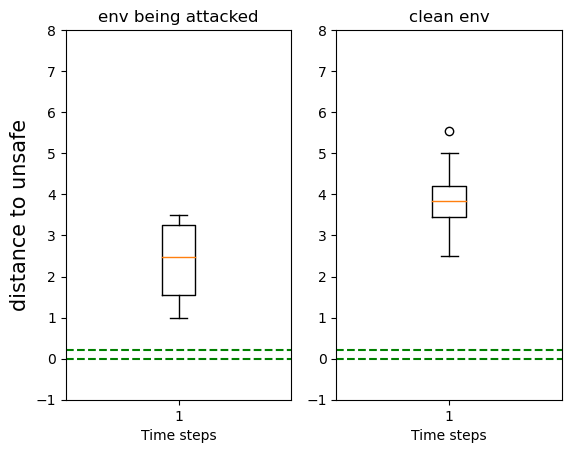

In [30]:
plt.subplot(1, 2, 1)
ave_dist = []
for i in range(10):
    ave_dist.append(sum(obs_dists_list[i]) / len(obs_dists_list[i]))
#     ave_dist.append(min(obs_dists_list[i]))
    # print(obs_dists_list[i])
    # plt.plot(np.arange(len(obs_dists_list[i])), obs_dists_list[i], color='red')
# print(ave_dist)
plt.boxplot(ave_dist)    
plt.ylim((-1, 8))   
plt.axhline(y=0.2, color='g', linestyle='--')
plt.axhline(y=0, color='g', linestyle='--')
plt.plot()
plt.xlabel('Time steps')
plt.ylabel('distance to unsafe', fontsize = 15)
plt.title('env being attacked')
# plt.show()


plt.subplot(1, 2, 2)
ave_dist = []
for i in range(10):
    ave_dist.append(sum(clean_obs_dists_list[i]) / len(clean_obs_dists_list[i]))
#     ave_dist.append(min(clean_obs_dists_list[i]))
    # plt.plot(np.arange(len(clean_obs_dists_list[i])), clean_obs_dists_list[i], color='green')
# print(ave_dist)
plt.boxplot(ave_dist)    
plt.ylim((-1, 8))       
plt.axhline(y=0.2, color='g', linestyle='--')
plt.axhline(y=0, color='g', linestyle='--')
plt.plot()
plt.xlabel('Time steps')
# plt.ylabel('obstacle distance')
plt.title('clean env')
plt.show()

In [52]:
#  train surrogate policy
reached = []
for k in [10]:
    env = DCEnv()
    env.k = k
    print('Start training with A2C ...')
    # learning_rate = 1e-3, n_steps = 1024, tune these
    surro_model = A2C("MlpPolicy", env, verbose=0)
    surro_model.learn(total_timesteps=300000, progress_bar=False)
    vec_env = surro_model.get_env()
    obs = vec_env.reset()
    env = DCEnv()
    env.k = 160
    state = env.reset()
    dims0 = []
    dims1 = []
    dims2 = []
    euclids = []
    center = np.array([math.pi / 2.0, 0, 0])
    obstacle = np.array([math.pi / 4.0, 0, 0])
    num_reached = 0
    for j in range(1000):
        dim0 = []
        dim1 = []
        dim2 = []
        euclid = []
        state = env.reset()
        # Print initial state
        for i in range(30):
            action, _states = model.predict(state, deterministic=True)
            new_state, reward, done, _ = env.step(action)
            dim0.append(state[0])
            dim1.append(state[1])
            dim2.append(state[2])
            dist = np.linalg.norm(state[:3]-center)
            obs_dist = np.linalg.norm(state[:3]-obstacle)
            euclid.append(dist)
            state = new_state
            if obs_dist <= 0.2:
                break
            if dist <= 0.5: # stop
                num_reached += 1
                break
        dims0.append(dim0)
        dims1.append(dim1)
        dims2.append(dim2)
        euclids.append(euclid)
    reached.append(num_reached)
#     print("Total number reached = " + str(num_reached))
print(reached)

Start training with DDPG ...
[1000]


In [54]:
# surro_model.save('A2C_motor.zip')

In [172]:
def grey_attack(env, state, model, surro_model, epsilon, policy, norm, args):
    action = surro_model.predict(state)[0]
#     print(action)
    effect = None
    attack = None
    _action = action
    _state = state
    

    def fun(x):
        return np.linalg.norm( env.sysd.A @ _state + env.sysd.B @ x - env.obstacle) 
    
    x_start = np.array(action)
    lim = [-10, 10]

    bounds = Bounds(lim[0], lim[1])  

#     x_state = odeint(bicycle, state, ts, args=(action,))[-1]
#     non_linear_eq= lambda x: np.linalg.norm(odeint(bicycle, state, ts, args=(x,))[-1] - env.obstacle) -\
#                             np.linalg.norm(odeint(bicycle, state, ts, args=(action,))[-1] - env.obstacle)
#     non_linear_constr = NonlinearConstraint(non_linear_eq, 0.0, np.inf)
#     result = minimize(fun, x_start, method='trust-constr', bounds=bounds, constraints=non_linear_constr)
    result = minimize(fun, x_start, method='trust-constr', bounds=bounds)
    # print(result.x)
    op_action = (result.x)
    state = torch.from_numpy(state)
    
    state = state.detach().unsqueeze(0).requires_grad_(True)
    # print(model.predict(state, deterministic=True)[0])
    next_origin_obs_dist = np.linalg.norm( env.sysd.A @ _state + env.sysd.B @ _action - env.obstacle) 
    effect = next_origin_obs_dist
    low, high = -10, 10
    for i in range(100):
     
        action = surro_model.policy._predict(state)[0].requires_grad_(True)
        action = torch.clip(action, low, high)
#         print(action)
#         action = action * 10
        action = action.double()
#         mse = nn.MSELoss()
        
        # compute the distance
        pdist = torch.nn.PairwiseDistance(p=2)
        loss = pdist(torch.tensor([op_action]), action)
        
        # loss = mse(torch.tensor([op_action]).requires_grad_(True), action)
        surro_model.policy.zero_grad()
        loss = loss.double()
        # print(action.dtype)
        loss.backward()
       
        state_grad = state.grad.detach().squeeze()
        perturbed_state = state - epsilon / 30 * state_grad.sign()
        # print(state_grad)
        # project!
        # print(perturbed_state[0])
        # torch.clamp(perturbed_state, min=(state - epsilon), max=(state + epsilon))
        # print(perturbed_state[0])
        
        scaled_action = surro_model.policy._predict(perturbed_state)[0]
        
#         action_next = (low + (0.5 * (scaled_action + 1.0) * (high - low)))
        action_next = torch.clip(scaled_action, low, high)
#         print(action_next.detach().numpy())
        state = perturbed_state.detach().requires_grad_(True)
#         print(f'state:{perturbed_state}')
        dist = np.linalg.norm(_state - env.center)
        obs_dist = np.linalg.norm(_state - env.obstacle)
        pertub_dist = np.linalg.norm(state.detach().numpy() - env.center)
        pertub_obs_dist = np.linalg.norm(state.detach().numpy() - env.obstacle)
        next_obs_dist =  np.linalg.norm( env.sysd.A @ _state + env.sysd.B @ action_next.detach().numpy()- env.obstacle)
        if pertub_obs_dist - env.safe_norm_radius > 0:
            
            if next_obs_dist < effect:
                effect = next_obs_dist
                # print(effect)
                attack = (state.detach().numpy() - _state)[0]
                
#     print(f'action:{_action}, action_pertubed:{action_next}, op_action:{op_action}')
    if attack is None:
        return np.zeros_like(_state)
    else:
        # print('find solution')
        

        return attack

In [173]:

# test grey box attack
norm = float('inf')
res_list = []
epsilon = 2
policy = None
args = None
env = DCEnv()
model = SAC.load("SAC_motor.zip", env=env)
surro_model = A2C.load('A2C_motor.zip', env=env)
clean_env = DCEnv()
state = env.reset()
dims0 = []
dims1 = []
dims2 = []
euclids = []
obs_dists = []
obs_dists_list = []
dist_list = []
center = env.center
obstacle =  env.obstacle
num_reached = 0
action_list = []
pertub_action_list = [] 
number_violate = 0
clean_obs_dists = []
clean_obs_dists_list = []
clean_num_reached = 0
clean_number_violate = 0
clean_obs_dist_list = []
clean_dist_list = []
for j in range(100):
    dim0 = []
    dim1 = []
    dim2 = []
    euclid = []
    state = env.reset()
    _ = clean_env.reset()
    clean_env.state = state
    clean_state = state
    # print(f'state:{state}, clean_state:{clean_state}')
    # Print initial state
    for i in range(env.step_const):
      
        # action = model.predict(state, deterministic=True)
        # pertub_action = safe_attack(env, state, model, epsilon, policy, norm, args)
        attack = grey_attack(env, state, model, surro_model,epsilon, policy, norm, args)
#         print(attack)
        pertub_state = state + attack
        # print(pertub_state, state)
        pertub_action = model.predict(pertub_state, deterministic=True)[0]
        # print(pertub_action)
        # new_state, reward, done, _ = env.step(pertub_action[0])
        new_state, reward, done, _ = env.step(pertub_action)
        state = new_state
        # new_state, reward, done, _ = env.step(action[0])
        
        dist = np.linalg.norm(state - env.center)
        obs_dist = np.linalg.norm(state - env.obstacle)
        pertub_action_list.append(pertub_action[0])
        # action_list.append(action)
        
        obs_dists.append(obs_dist)
        if obs_dist <= env.safe_norm_radius:
            number_violate += 1
            break
        if dist <= env.target_norm_radius: # stop
            num_reached += 1
            break
        
    # print(obs_dists)
    # print('++++++++++++++++')
    obs_dists_list.append(obs_dists)
    obs_dists = []
    
    # print(env.final_reward_cache)
    # print("dirty env")
    # print(obs_dist_list)
    # print(dist_list)
   
    for i in range(env.step_const):
        clean_action = model.predict(clean_state, deterministic=True)
        clean_new_state, reward, done, _ = clean_env.step(clean_action[0])
        clean_state = clean_new_state
        clean_dist = np.linalg.norm(clean_state - clean_env.center)
        clean_obs_dist = np.linalg.norm(clean_state - clean_env.obstacle)
        # euclid.append(dist)
        
        # clean_obs_dist_list.append(clean_obs_dist)
        clean_dist_list.append(clean_dist)
        clean_obs_dists.append(clean_obs_dist)
        if clean_obs_dist <= env.safe_norm_radius:
            clean_number_violate += 1
            break
        if clean_dist <=  env.target_norm_radius: # stop
            clean_num_reached += 1
            break
    # print(clean_obs_dists)
    # print('-------------------')
    clean_obs_dists_list.append(clean_obs_dists)
    clean_obs_dists = []
    
    # print(clean_env.final_reward_cache)
    # print("clean env")
    # print(clean_obs_dist_list)
    # print(clean_dist_list)
   
    # dims0.append(dim0)
    # dims1.append(dim1)
    # dims2.append(dim2)
    euclids.append(euclid)
ref= [math.pi/2]*30
print("Total number reached = " + str(num_reached))
print("Total number violate = " + str(number_violate))
# print("average of obs dist= " + str(sum(obs_dist_list) / len(obs_dist_list)))
res_list.append(num_reached)
print("clean env for reference")
print("Total number reached = " + str(clean_num_reached))
print("Total number violate = " + str(clean_number_violate))
# print("average of obs dist= " + str(sum(clean_obs_dist_list) / len(clean_obs_dist_list)))

/home/cpsl/anaconda3/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Total number reached = 67
Total number violate = 0
clean env for reference
Total number reached = 84
Total number violate = 0


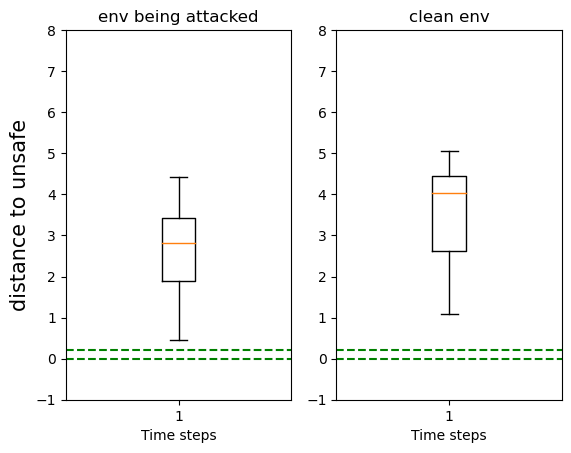

In [175]:
plt.subplot(1, 2, 1)
ave_dist = []
for i in range(50):
    ave_dist.append(sum(obs_dists_list[i]) / len(obs_dists_list[i]))
#     ave_dist.append(min(obs_dists_list[i]))
    # print(obs_dists_list[i])
    # plt.plot(np.arange(len(obs_dists_list[i])), obs_dists_list[i], color='red')
# print(ave_dist)
plt.boxplot(ave_dist)    
plt.ylim((-1, 8))   
plt.axhline(y=0.2, color='g', linestyle='--')
plt.axhline(y=0, color='g', linestyle='--')
plt.plot()
plt.xlabel('Time steps')
plt.ylabel('distance to unsafe', fontsize = 15)
plt.title('env being attacked')
# plt.show()


plt.subplot(1, 2, 2)
ave_dist = []
for i in range(50):
    ave_dist.append(sum(clean_obs_dists_list[i]) / len(clean_obs_dists_list[i]))
#     ave_dist.append(min(clean_obs_dists_list[i]))
    # plt.plot(np.arange(len(clean_obs_dists_list[i])), clean_obs_dists_list[i], color='green')
# print(ave_dist)
plt.boxplot(ave_dist)    
plt.ylim((-1, 8))       
plt.axhline(y=0.2, color='g', linestyle='--')
plt.axhline(y=0, color='g', linestyle='--')
plt.plot()
plt.xlabel('Time steps')
# plt.ylabel('obstacle distance')
plt.title('clean env')
plt.show()

In [156]:
class adv_DCEnv(gym.Env):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }

    def __init__(self, render_mode: Optional[str] = None, g=10.0):
        super(adv_DCEnv, self).__init__()
        self.max_speed = -10
        self.max_torque = 10
        self.dt = 0.05

        self.render_mode = render_mode

        self.screen_dim = 500
        self.screen = None
        self.clock = None
        self.isopen = True
        self.center = np.array([math.pi / 2.0, 0, 0])
        self.obstacle = np.array([math.pi / 4.0, 0, 0])
        count = 0
        J = 0.01
        b = 0.1
        K = 0.01
        R = 1
        L = 0.5
        self.A = np.array([[0, 1, 0],
         [0, -b / J, K / J],
         [0, -K / L, -R / L]])
        self.A_dim = len(self.A)
        self.B = np.array([[0], [0], [1 / L]])
        self.xmeasure = 0
        self.attacked_element_idx = 0
        self.C = np.array([[1, 0, 0]])
        self.D = np.array([[0]])
        self.Q = np.eye(self.A_dim)
        self.R = np.array([[1]])
        self.dt = 0.2
        self.x_ref = np.array([[0], [0], [0]]) # 4th dim is remaining steps
        # store current trace
        self.cache1 = []
        self.cache2 = []
        self.cache3 = []
        self.x0 = np.copy(self.x_ref)
        self.u_upbound_tuned = np.array([[10]])
        # ball radius
        self.target_norm_radius = 0.5 # norm ball radius of target, tune this
        self.safe_norm_radius = 0.2 # norm ball radius of safe, tune this
        self.total_time = 120
        # step number
        self.steps = 0
        self.u_lowbound = None
        # store training traces
        self.state_array_1 = []
        self.state_array_2 = []
        self.state_array_3 = []
        self.caches = []
        self.reward_cache = [] # cache distances to target norm ball center
        self.avoid_reward_cache = [] # cache distances to obstacles norm ball center
        self.final_reward_cache = [] # cache final reward
        # How long should this trace be, i.e. deadline
        self.step_const = random.randint(10, 50)
        # Maximum reward from each trace
        self.max_reward_list = []
        self.quality_list = []
        self.total_steps = 0
        self.step_history = []
        self.sysc = ss(self.A, self.B, self.C, self.D)
        self.sysd = c2d(self.sysc, self.dt)
        
        high = np.array(self.x_ref.flatten(), dtype=np.float32)
        self.action_space = spaces.Box(
            low=-self.max_torque, high=self.max_torque, shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)
        self.reached = False
        self.k = 20
    def step(self, u):
        
        # simulate next step and get measurement
        self.steps += 1
        self.total_steps += 1
        terminated = False
        dt = self.dt
        u = np.clip(u, -self.max_torque, self.max_torque)[0]
        self.last_u = u 
        costs = 1
        yout, T, xout = lsim(self.sysc, self.last_u, [0, self.dt], self.xmeasure)
        self.xmeasure = xout[-1]
        
        # calculate euclidean distance and update reward cache
        dist = np.linalg.norm(self.xmeasure - self.center)
        obs_dist = np.linalg.norm(self.xmeasure - self.obstacle)
#         reward = self.target_norm_radius - dist
        obs_reward = obs_dist-self.safe_norm_radius
        obs_reward = -obs_reward
#         self.reward_cache.append(reward)
        self.avoid_reward_cache.append(obs_reward)
        # quantitative semantics
        # reach reward, encourage reaching target
#         if self.steps < 10:
#             reach_reward = max(self.reward_cache)
#         else:
#             reach_reward = max(self.reward_cache[-10:])
        if self.steps < 10:
            avoid_reward = max(self.avoid_reward_cache)
        else:
            avoid_reward = max(self.avoid_reward_cache[-10:])   
        final_reward = avoid_reward
                    
#         # very strict reward, always within target
#         strict_avoid_reward = avoid_reward - 0.5 * self.safe_norm_radius # half safe norm radius
#         strict_reach_reward = reach_reward - 0.5 * self.target_norm_radius # half target norm radius
        
        # overall reward, pick one of the final_reward
#         final_reward = reach_reward
#         final_reward = approach_reward
#         final_reward = min(reach_reward, avoid_reward) # reach and avoid
#         final_reward = min(approach_reward, avoid_reward) # approach and avoid
#         final_reward = min(reach_reward, approach_reward) # reach and approach
#         deadline_reward = (self.last_dist-dist)/(self.step_const - self.steps+1) 
#         final_reward = reach_reward
        # split cases: if already inside target, give very large constant reward for maintaining
#         if dist <= self.target_norm_radius:
#             final_reward = 10 # this gives 39/50 sucess with reach+approach+avoid
        if obs_dist <= self.safe_norm_radius:
            final_reward = 10
        self.final_reward_cache.append(final_reward)
        
        # update cached memory
        self.state = self.xmeasure
        self.state_array_1.append(self.state[0])
        self.state_array_2.append(self.state[1])
        self.state_array_3.append(self.state[2])
        self.cache1.append(self.state[0])
        self.cache2.append(self.state[1])
        self.cache3.append(self.state[2])
        self.last_dist = dist
        # If this is the last step, reset the state
        if self.steps == self.step_const or obs_dist<=self.safe_norm_radius:
            self.max_reward_list.append(max(self.final_reward_cache)) # use max final reward to measure episodes
            self.step_history.append(self.total_steps)
            self.quality_list.append(sum(self.final_reward_cache))
            terminated = True
            self.reset()
            
#         # If within target norm ball, early terminate
#         if dist <= self.target_norm_radius:
#             terminated = True
#             self.reset()
        
        # Return next state, reward, done, info
        return self._get_obs(), final_reward, terminated, {}
        
    def reset(self):
        self.state = np.array([random.random()*math.pi, random.random()*2-1, random.random()*20-10])
        self.reward_cache = []
        self.final_reward_cache = []
        self.steps=0
        self.caches.append(self.cache1)
        self.caches.append(self.cache2)
        self.caches.append(self.cache3)
        self.cache1 = []
        self.cache2 = []
        self.cache3 = []
        self.xmeasure = self.state
        # random # of steps for this trace
        self.step_const = self.k # deadline range
        self.reached = False
        return np.array(self.state) # return something matching shape
    
    def _get_obs(self):
        current_state = list(self.state)
        return np.array(current_state)
    
    def render(self):
        return
    
    def close(self):
        if self.screen is not None:
            import pygame
            pygame.display.quit()
            pygame.quit()
            self.isopen = False

In [91]:
#  train adv policy to collide with obstacle
reached = []
for k in [10]:
    env = adv_DCEnv()
    env.k = k
    print('Start training with A2C ...')
    # learning_rate = 1e-3, n_steps = 1024, tune these
    adv_model = A2C("MlpPolicy", env, verbose=0)
    adv_model.learn(total_timesteps=300000, progress_bar=False)
    vec_env = adv_model.get_env()
    obs = vec_env.reset()
    env = DCEnv()
    env.k = 160
    state = env.reset()
    dims0 = []
    dims1 = []
    dims2 = []
    euclids = []
    center = np.array([math.pi / 2.0, 0, 0])
    obstacle = np.array([math.pi / 4.0, 0, 0])
    num_reached = 0
    for j in range(1000):
        dim0 = []
        dim1 = []
        dim2 = []
        euclid = []
        state = env.reset()
        # Print initial state
        for i in range(30):
            action, _states = adv_model.predict(state, deterministic=True)
            new_state, reward, done, _ = env.step(action)
            dim0.append(state[0])
            dim1.append(state[1])
            dim2.append(state[2])
            dist = np.linalg.norm(state[:3]-center)
            obs_dist = np.linalg.norm(state[:3]-obstacle)
            euclid.append(dist)
            state = new_state
            if obs_dist <= 0.2:
                break
#             if dist <= 0.5: # stop
#                 num_reached += 1
#                 break
        dims0.append(dim0)
        dims1.append(dim1)
        dims2.append(dim2)
        euclids.append(euclid)
    reached.append(num_reached)
#     print("Total number reached = " + str(num_reached))
print(reached)

Start training with A2C ...
[0]


In [92]:
adv_model.save('adv_A2C_motor.zip')

In [158]:
def black_attack(env, state, model, surro_model,adv_model, epsilon, policy, norm, args):
    action = surro_model.predict(state)[0]
#     print(action)
    effect = None
    attack = None
    _action = action
    _state = state
    
#     def f(x):
#     # Objective function
#         return 1
#     def fun(x):
#         return np.linalg.norm( env.sysd.A @ _state + env.sysd.B @ x - env.obstacle) 
    
#     x_start = np.array(action)
#     lim = [-10, 10]

#     bounds = Bounds(lim[0], lim[1])  

# #     x_state = odeint(bicycle, state, ts, args=(action,))[-1]
# #     non_linear_eq= lambda x: np.linalg.norm(odeint(bicycle, state, ts, args=(x,))[-1] - env.obstacle) -\
# #                             np.linalg.norm(odeint(bicycle, state, ts, args=(action,))[-1] - env.obstacle)
# #     non_linear_constr = NonlinearConstraint(non_linear_eq, 0.0, np.inf)
# #     result = minimize(f, x_start, method='trust-constr', bounds=bounds, constraints=non_linear_constr)
#     result = minimize(f, x_start, method='trust-constr', bounds=bounds)
#     # print(result.x)
    op_action = adv_model.predict(state)[0]
#     op_action = (result.x)
    state = torch.from_numpy(state)
    
    state = state.detach().unsqueeze(0).requires_grad_(True)
    # print(model.predict(state, deterministic=True)[0])
    next_origin_obs_dist = np.linalg.norm( env.sysd.A @ _state + env.sysd.B @ _action - env.obstacle) 
    effect = next_origin_obs_dist
    for i in range(100):
     
        action = surro_model.policy._predict(state)[0].requires_grad_(True)
#         print(action)
#         action = action * 10
        action = action.double()
        mse = nn.MSELoss()
        
        # compute the distance
        pdist = torch.nn.PairwiseDistance(p=2)
        loss = pdist(torch.tensor([op_action]), action)
        
        # loss = mse(torch.tensor([op_action]).requires_grad_(True), action)
        surro_model.policy.zero_grad()
        loss = loss.double()
        # print(action.dtype)
        loss.backward()
       
        state_grad = state.grad.detach().squeeze()
        perturbed_state = state - epsilon / 30 * state_grad.sign()
        # print(state_grad)
        # project!
        # print(perturbed_state[0])
        # torch.clamp(perturbed_state, min=(state - epsilon), max=(state + epsilon))
        # print(perturbed_state[0])
        
        scaled_action = surro_model.policy._predict(perturbed_state)[0]
        low, high = -10, 10
#         action_next = (low + (0.5 * (scaled_action + 1.0) * (high - low)))
        action_next = torch.clip(scaled_action, low, high)
#         print(action_next.detach().numpy())
        state = perturbed_state.detach().requires_grad_(True)
#         print(f'state:{perturbed_state}')
    # print(f'action:{_action}, action_pertubed:{action_next}, op_action:{op_action}')
        dist = np.linalg.norm(_state - env.center)
        obs_dist = np.linalg.norm(_state - env.obstacle)
        pertub_dist = np.linalg.norm(state.detach().numpy() - env.center)
        pertub_obs_dist = np.linalg.norm(state.detach().numpy() - env.obstacle)
        next_obs_dist =  np.linalg.norm( env.sysd.A @ _state + env.sysd.B @ action_next.detach().numpy()- env.obstacle)
        if pertub_obs_dist - env.safe_norm_radius > 0:
            
            if next_obs_dist < effect:
                effect = next_obs_dist
                # print(effect)
                attack = (state.detach().numpy() - _state)[0]
    if attack is None:
        return np.zeros_like(_state)
    else:
        # print('find solution')
        return attack

In [95]:

# test black box attack
norm = float('inf')
res_list = []
epsilon = 2
policy = None
args = None
env = DCEnv()
adv_env = adv_DCEnv()
model = SAC.load("SAC_motor.zip", env=env)
surro_model = A2C.load('A2C_motor.zip', env=env)
adv_model = A2C.load('adv_A2C_motor.zip', env=adv_env)
clean_env = DCEnv()
state = env.reset()
dims0 = []
dims1 = []
dims2 = []
euclids = []
obs_dists = []
obs_dists_list = []
dist_list = []
center = env.center
obstacle =  env.obstacle
num_reached = 0
action_list = []
pertub_action_list = [] 
number_violate = 0
clean_obs_dists = []
clean_obs_dists_list = []
clean_num_reached = 0
clean_number_violate = 0
clean_obs_dist_list = []
clean_dist_list = []
for j in range(100):
    dim0 = []
    dim1 = []
    dim2 = []
    euclid = []
    state = env.reset()
    _ = clean_env.reset()
    clean_env.state = state
    clean_state = state
    # print(f'state:{state}, clean_state:{clean_state}')
    # Print initial state
    for i in range(env.step_const):
      
        # action = model.predict(state, deterministic=True)
        # pertub_action = safe_attack(env, state, model, epsilon, policy, norm, args)
        attack = black_attack(env, state, model, surro_model,adv_model, epsilon, policy, norm, args)
#         print(attack)
        pertub_state = state + attack
        # print(pertub_state, state)
        pertub_action = model.predict(pertub_state, deterministic=True)[0]
        # print(pertub_action)
        # new_state, reward, done, _ = env.step(pertub_action[0])
        new_state, reward, done, _ = env.step(pertub_action)
        state = new_state
        # new_state, reward, done, _ = env.step(action[0])
        
        dist = np.linalg.norm(state - env.center)
        obs_dist = np.linalg.norm(state - env.obstacle)
        pertub_action_list.append(pertub_action[0])
        # action_list.append(action)
        
        obs_dists.append(obs_dist)
        if obs_dist <= env.safe_norm_radius:
            number_violate += 1
            break
        if dist <= env.target_norm_radius: # stop
            num_reached += 1
            break
        
    # print(obs_dists)
    # print('++++++++++++++++')
    obs_dists_list.append(obs_dists)
    obs_dists = []
    
    # print(env.final_reward_cache)
    # print("dirty env")
    # print(obs_dist_list)
    # print(dist_list)
   
    for i in range(env.step_const):
        clean_action = model.predict(clean_state, deterministic=True)
        clean_new_state, reward, done, _ = clean_env.step(clean_action[0])
        clean_state = clean_new_state
        clean_dist = np.linalg.norm(clean_state - clean_env.center)
        clean_obs_dist = np.linalg.norm(clean_state - clean_env.obstacle)
        # euclid.append(dist)
        
        # clean_obs_dist_list.append(clean_obs_dist)
        clean_dist_list.append(clean_dist)
        clean_obs_dists.append(clean_obs_dist)
        if clean_obs_dist <= env.safe_norm_radius:
            clean_number_violate += 1
            break
        if clean_dist <=  env.target_norm_radius: # stop
            clean_num_reached += 1
            break
    # print(clean_obs_dists)
    # print('-------------------')
    clean_obs_dists_list.append(clean_obs_dists)
    clean_obs_dists = []
    
    # print(clean_env.final_reward_cache)
    # print("clean env")
    # print(clean_obs_dist_list)
    # print(clean_dist_list)
   
    # dims0.append(dim0)
    # dims1.append(dim1)
    # dims2.append(dim2)
    euclids.append(euclid)
ref= [math.pi/2]*30
print("Total number reached = " + str(num_reached))
print("Total number violate = " + str(number_violate))
# print("average of obs dist= " + str(sum(obs_dist_list) / len(obs_dist_list)))
res_list.append(num_reached)
print("clean env for reference")
print("Total number reached = " + str(clean_num_reached))
print("Total number violate = " + str(clean_number_violate))
# print("average of obs dist= " + str(sum(clean_obs_dist_list) / len(clean_obs_dist_list)))

Total number reached = 75
Total number violate = 0
clean env for reference
Total number reached = 100
Total number violate = 0


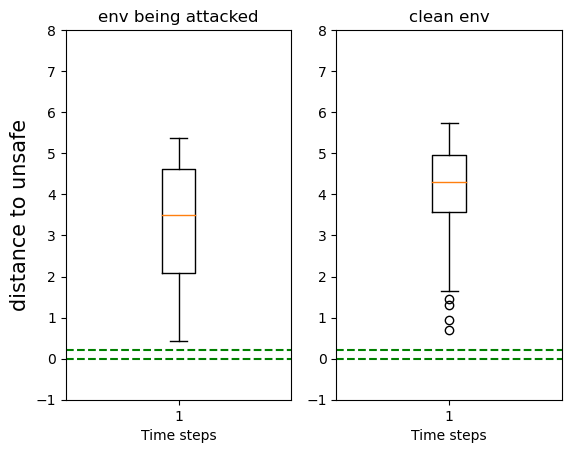

In [96]:
plt.subplot(1, 2, 1)
ave_dist = []
for i in range(50):
    ave_dist.append(sum(obs_dists_list[i]) / len(obs_dists_list[i]))
#     ave_dist.append(min(obs_dists_list[i]))
    # print(obs_dists_list[i])
    # plt.plot(np.arange(len(obs_dists_list[i])), obs_dists_list[i], color='red')
# print(ave_dist)
plt.boxplot(ave_dist)    
plt.ylim((-1, 8))   
plt.axhline(y=0.2, color='g', linestyle='--')
plt.axhline(y=0, color='g', linestyle='--')
plt.plot()
plt.xlabel('Time steps')
plt.ylabel('distance to unsafe', fontsize = 15)
plt.title('env being attacked')
# plt.show()


plt.subplot(1, 2, 2)
ave_dist = []
for i in range(50):
    ave_dist.append(sum(clean_obs_dists_list[i]) / len(clean_obs_dists_list[i]))
#     ave_dist.append(min(clean_obs_dists_list[i]))
    # plt.plot(np.arange(len(clean_obs_dists_list[i])), clean_obs_dists_list[i], color='green')
# print(ave_dist)
plt.boxplot(ave_dist)    
plt.ylim((-1, 8))       
plt.axhline(y=0.2, color='g', linestyle='--')
plt.axhline(y=0, color='g', linestyle='--')
plt.plot()
plt.xlabel('Time steps')
# plt.ylabel('obstacle distance')
plt.title('clean env')
plt.show()

In [ ]:

# test white, grey, black box attack
norm = float('inf')
res_list = []
epsilon = 2
policy = None
args = None
env = DCEnv()
adv_env = adv_DCEnv()
model = SAC.load("SAC_motor.zip", env=env)
surro_model = A2C.load('A2C_motor.zip', env=env)
adv_model = A2C.load('adv_A2C_motor.zip', env=adv_env)
clean_env = DCEnv()
black_env = DCEnv()
white_env = DCEnv()
grey_env = DCEnv()
all_envs = [clean_env, white_env, grey_env, black_env]
state = env.reset()

# obs_dists = []
# obs_dists_list = []
# dist_list = []
center = env.center
obstacle =  env.obstacle
# num_reached = 0
# action_list = []
# pertub_action_list = [] 
# number_violate = 0
clean_obs_dists = []
clean_obs_dists_list = []
clean_num_reached = 0
clean_number_violate = 0
clean_obs_dist_list = []
clean_dist_list = []
black_obs_dists = []
black_obs_dists_list = []
black_num_reached = 0
black_number_violate = 0
black_obs_dist_list = []
black_dist_list = []
grey_obs_dists = []
grey_obs_dist_list = []
grey_num_reached = 0
grey_number_violate = 0
grey_obs_dists_list = []
grey_dist_list = []
white_obs_dists = []
white_obs_dists_list = []
white_num_reached = 0
white_number_violate = 0
white_obs_dist_list = []
white_dist_list = []


for j in range(100):
    _ = [env.reset() for env in all_envs]
    for env in all_envs:
        env.state = clean_env.state
    
# black-box
    state = black_env.state
    for i in range(env.step_const):
        
        attack = black_attack(black_env, state, model, surro_model,adv_model, epsilon, policy, norm, args)
#         print(f'black_attack:{attack}')
        pertub_state = state + attack
        pertub_action = model.predict(pertub_state, deterministic=True)[0]
        new_state, reward, done, _ = black_env.step(pertub_action)
        state = new_state        
        dist = np.linalg.norm(state - black_env.center)
        obs_dist = np.linalg.norm(state - black_env.obstacle)
#         pertub_action_list.append(pertub_action[0])
        # action_list.append(action)
        
        black_obs_dists.append(obs_dist)
        if obs_dist <= black_env.safe_norm_radius:
            black_number_violate += 1
            break
        if dist <= black_env.target_norm_radius: # stop
            black_num_reached += 1
            break
        
    # print(obs_dists)
    # print('++++++++++++++++')
    black_obs_dists_list.append(black_obs_dists)
    black_obs_dists = []
    
# grey-box
    state = grey_env.state
    for i in range(env.step_const):
        
        attack = grey_attack(grey_env, state, model, surro_model, epsilon, policy, norm, args)
#         print(f'grey_attack:{attack}')
        pertub_state = state + attack
        pertub_action = model.predict(pertub_state, deterministic=True)[0]
        new_state, reward, done, _ = grey_env.step(pertub_action)
        state = new_state        
        dist = np.linalg.norm(state - grey_env.center)
        obs_dist = np.linalg.norm(state - grey_env.obstacle)
        
        grey_obs_dists.append(obs_dist)
        if obs_dist <= grey_env.safe_norm_radius:
            grey_number_violate += 1
            break
        if dist <= grey_env.target_norm_radius: # stop
            grey_num_reached += 1
            break
        
    # print(obs_dists)
    # print('++++++++++++++++')
    grey_obs_dists_list.append(grey_obs_dists)
    grey_obs_dists = []
    
    
# white
    state = white_env.state
    for i in range(env.step_const):
        
        attack = safe_attack(white_env, state, model, epsilon, policy, norm, args)
#         print(attack)
        pertub_state = state + attack
        pertub_action = model.predict(pertub_state, deterministic=True)[0]
        new_state, reward, done, _ = white_env.step(pertub_action)
        state = new_state        
        dist = np.linalg.norm(state - white_env.center)
        obs_dist = np.linalg.norm(state - white_env.obstacle)
        
        white_obs_dists.append(obs_dist)
        if obs_dist <= white_env.safe_norm_radius:
            white_number_violate += 1
            break
        if dist <= white_env.target_norm_radius: # stop
            white_num_reached += 1
            break
        
    # print(obs_dists)
    # print('++++++++++++++++')
    white_obs_dists_list.append(white_obs_dists)
    white_obs_dists = []

#    clean env
    clean_state = clean_env.state
    for i in range(env.step_const):
        clean_action = model.predict(clean_state, deterministic=True)
        clean_new_state, reward, done, _ = clean_env.step(clean_action[0])
        clean_state = clean_new_state
        clean_dist = np.linalg.norm(clean_state - clean_env.center)
        clean_obs_dist = np.linalg.norm(clean_state - clean_env.obstacle)
        # euclid.append(dist)
        
        # clean_obs_dist_list.append(clean_obs_dist)
        clean_dist_list.append(clean_dist)
        clean_obs_dists.append(clean_obs_dist)
        if clean_obs_dist <= env.safe_norm_radius:
            clean_number_violate += 1
            break
        if clean_dist <=  env.target_norm_radius: # stop
            clean_num_reached += 1
            break
    # print(clean_obs_dists)
    # print('-------------------')
    clean_obs_dists_list.append(clean_obs_dists)
    clean_obs_dists = []

ref= [math.pi/2]*30
print("black env for reference")
print("Total number reached = " + str(black_num_reached))
print("Total number violate = " + str(black_number_violate))
# print("average of obs dist= " + str(sum(obs_dist_list) / len(obs_dist_list)))


# print("average of obs dist= " + str(sum(clean_obs_dist_list) / len(clean_obs_dist_list)))
print("grey env for reference")
print("Total number reached = " + str(grey_num_reached))
print("Total number violate = " + str(grey_number_violate))
print("white env for reference")
print("Total number reached = " + str(white_num_reached))
print("Total number violate = " + str(white_number_violate))
print("clean env for reference")
print("Total number reached = " + str(clean_num_reached))
print("Total number violate = " + str(clean_number_violate))

/home/cpsl/anaconda3/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [ ]:
label = ['white', 'grey', 'black', 'clean']
black = []
white = []
grey = []
clean = []
for i in range(100):
    black.append(sum(black_obs_dists_list[i]) / len(black_obs_dists_list[i]))
    white.append(sum(white_obs_dists_list[i]) / len(white_obs_dists_list[i]))
    grey.append(sum(grey_obs_dists_list[i]) / len(grey_obs_dists_list[i]))
    clean.append(sum(clean_obs_dists_list[i]) / len(clean_obs_dists_list[i]))
#     black.append(min(black_obs_dists_list[i]) )
#     white.append(min(white_obs_dists_list[i]))
#     grey.append(min(grey_obs_dists_list[i]))
#     clean.append(min(clean_obs_dists_list[i]))
data = [white, grey, black, clean]
ax = plt.boxplot(data)    
plt.ylim((-1, 8))   
plt.axhline(y=0.2, color='g', linestyle='--')
plt.axhline(y=0, color='g', linestyle='--')
plt.plot()
plt.xlabel('Attacker knowledge')
plt.ylabel('Average distance to unsafe', fontsize = 15)
# plt.title('Average distance to unsafe')
plt.xticks([1, 2, 3, 4], label)
# plt.legend([ax["boxes"][0], ax["boxes"][1]], ['white', 'grey'], loc='upper right')
# plt.show()


In [141]:

# test origin policy and surrogate model
norm = float('inf')
res_list = []
epsilon = 2
policy = None
args = None
env = DCEnv()
adv_env = adv_DCEnv()
model = SAC.load("SAC_motor.zip", env=env)
surro_model = A2C.load('A2C_motor.zip', env=env)
adv_model = A2C.load('adv_A2C_motor.zip', env=adv_env)
surro_env = DCEnv()
all_envs = [env, surro_env]
state = env.reset()


center = env.center
obstacle =  env.obstacle
number_violate = 0
num_reached = 0
surro_number_violate = 0
surro_num_reached = 0
dim0 = []
dim1 = []
dim2 = []
dims0 = []
dims1 = []
dims2 = []
surro_dim0 = []
surro_dim1 = []
surro_dim2 = []
surro_dims0 = []
surro_dims1 = []
surro_dims2 = []
for j in range(100):
    _ = [env.reset() for env in all_envs]
    for env in all_envs:
        env.state =  np.array([math.pi - 3, -0.5, -10])

        # white
        
    state = env.state
    for i in range(env.step_const):
        dim0.append(state[0])
        dim1.append(state[1])
        dim2.append(state[2])
        action = model.predict(state, deterministic=True)[0]
        new_state, reward, done, _ = env.step(action)
        state = new_state        
        dist = np.linalg.norm(state - env.center)
        obs_dist = np.linalg.norm(state - env.obstacle)
        
#         white_obs_dists.append(obs_dist)
        if obs_dist <= env.safe_norm_radius:
            number_violate += 1
            break
        if dist <= env.target_norm_radius: # stop
            num_reached += 1
            break
    dims0.append(dim0)
    dims1.append(dim1)
    dims2.append(dim2)
    dim0 = []
    dim1 = []
    dim2 = []
    
    
    state = surro_env.state
    for i in range(env.step_const):
        surro_dim0.append(state[0])
        surro_dim1.append(state[1])
        surro_dim2.append(state[2])
        action = surro_model.predict(state, deterministic=True)[0]
        new_state, reward, done, _ = surro_env.step(action)
        state = new_state        
        dist = np.linalg.norm(state - surro_env.center)
        obs_dist = np.linalg.norm(state - surro_env.obstacle)
        
#         white_obs_dists.append(obs_dist)
        if obs_dist <= surro_env.safe_norm_radius:
            surro_number_violate += 1
            break
        if dist <= surro_env.target_norm_radius: # stop
            surro_num_reached += 1
            break
    surro_dims0.append(dim0)
    surro_dims1.append(dim1)
    surro_dims2.append(dim2)
    surro_dim0 = []
    surro_dim1 = []
    surro_dim2 = []
print('done')
    # print('++++++++++++++++')
#     obs_dists_list.append(white_obs_dists)
#     obs_dists = []

done


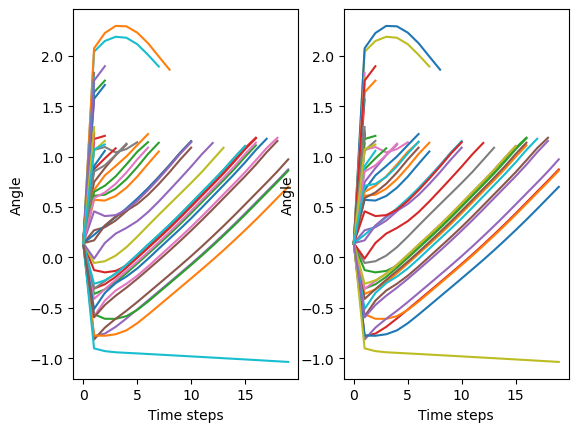

In [144]:
plt.subplot(1,2,1)
for i in range(50):
    plt.plot(dims0[i])
plt.plot()
plt.xlabel('Time steps')
plt.ylabel('Angle')
# plt.show()
plt.subplot(1,2,2)
for i in range(50):
    plt.plot(surro_dims0[i])
plt.plot()
plt.xlabel('Time steps')
plt.ylabel('Angle')
plt.show()